# Downloading COVID Data From FloridaDisaster.ORG

### To Do
- [ ] Turn all of the processes into functions
- [X] Fix/find out why reports 3/19 - 3/24 are only 1kb and hold no data (There were 3 different page titles not 2)
- [X] Clean the changing column names at the text export stage
- [X] Figure out my headers are messed up
- [ ] Why are there so many obs for 3/18
- [ ] **IMPORTANT**: THE LARGE NEGATIVE NUMBERS FOR DADE DO NOT SEEM TO BE CORRECT. FIND OUT WHAT IS GOING ON THERE
- [ ] 
- [X] Fix the problem where before doh reported 0 as 0 and not missing, I can't use the data
- [X] Extract the page range 12-25
- [X] Find the pages that contain the words "Coronavirus: All persons tested"
- [X] Extract just those two pages pdf 
- [X] Export individual files to txt for storage



In [296]:
from selenium import webdriver
import os
import wget
import PyPDF2 as pdf
from PyPDF2 import PdfFileReader, PdfFileWriter
import time
import textract
from pathlib import Path
import re
import pandas as pd
import datetime

In [306]:
chrome_path = r"chromedriver.exe"

## Initializing driver element and finding 

In [307]:
driver = webdriver.Chrome(chrome_path)

In [308]:
driver.get('https://floridadisaster.org/covid19/covid-19-data-reports/')
title = driver.title
time.sleep(3)
result = driver.find_elements_by_xpath("//a[@href]")

Initializing the output paths

In [295]:
output_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\PDF')
pdf_output_path= output_path.resolve()
pdf_extract_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\Unclean PDF')
pdf_extract_path = pdf_extract_path.resolve()

In [8]:
pdf_output_path

WindowsPath('C:/Users/chacr/OneDrive/Documents/Coding/Python/USF/COVID-19 Project/Data/PDF')

## Downloads the PDF Files from the FDEM Website

In [9]:
link_counter = 0
len_result = len(result)
for links in result:
    if links.text.find('Data Report') > 0:
        link_url = links.get_attribute('href')
        filename = wget.filename_from_url(link_url)
        if not os.path.exists(f'{pdf_output_path}/{filename}'):
            wget.download(link_url, out = f'{pdf_output_path}')
        link_counter +=1
        print (f'{round((link_counter * 2)/len_result,3)*100}% Complete',end='\r')

In [309]:
driver.close()

### Extracting the min and max page range for the COVID-19 Daily County Data

In [303]:
#turn into a function
def PdfPageExtract(input_path, output_path, page_num):
    import time
    import os
    import PyPDF2 as pdf
    from PyPDF2 import PdfFileReader, PdfFileWriter
    import textract
    print('Program Started')
    page_counter = 0
    today = datetime.date.today()
    file_num = len(os.listdir(input_path))
    file_exist_n =0
    progress = 0
    for files in os.listdir(input_path):
        output = f'{output_path}/(7-11-20) Unclean Extract from {files}'
        progress += 1
        if os.path.exists(output):
            file_exist_n +=1
            print(f'{round((progress/file_num)* 100,3)}% Complete')
            continue
        else:

            pdf_writer = PdfFileWriter()
            pdf_file = open(f'{input_path}/{files}','rb')
            pdfreader = PdfFileReader(pdf_file)
            num_pages = pdfreader.numPages
            if num_pages < page_num:
                up_limit = num_pages
            else:
                up_limit = page_num
            for pages in range(3, up_limit):
                page =  pdfreader.getPage(pages)  
                if page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All persons tested') > 0 or page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All') > 0:
                    pdf_writer.addPage(page)          
            with open(output, 'wb') as output_pdf:
                pdf_writer.write(output_pdf)
            print(f'{round((progress/file_num)* 100,3)}% Complete')
    
    if file_exist_n == file_num:
        print('All Files Previously Created')
    else:
        print(f'{file_num -file_exist_n} New Files Created')

page_limit = 23

PdfPageExtract(pdf_output_path, pdf_extract_path, page_limit)


Program Started
0.662% Complete
1.325% Complete
1.987% Complete
2.649% Complete
3.311% Complete
3.974% Complete
4.636% Complete
5.298% Complete
5.96% Complete
6.623% Complete
7.285% Complete
7.947% Complete
8.609% Complete
9.272% Complete
9.934% Complete
10.596% Complete
11.258% Complete
11.921% Complete
12.583% Complete
13.245% Complete
13.907% Complete
14.57% Complete
15.232% Complete
15.894% Complete
16.556% Complete
17.219% Complete
17.881% Complete
18.543% Complete
19.205% Complete
19.868% Complete
20.53% Complete
21.192% Complete
21.854% Complete
22.517% Complete
23.179% Complete
23.841% Complete
24.503% Complete
25.166% Complete
25.828% Complete
26.49% Complete
27.152% Complete
27.815% Complete
28.477% Complete
29.139% Complete
29.801% Complete
30.464% Complete
31.126% Complete
31.788% Complete
32.45% Complete
33.113% Complete
33.775% Complete
34.437% Complete
35.099% Complete
35.762% Complete
36.424% Complete
37.086% Complete
37.748% Complete
38.411% Complete
39.073% Complete
3

# Converting the PDFs to html files

In [310]:
from pathlib import Path

input_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\Unclean PDF')
output_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\html')
ip = input_path.resolve()
op = output_path.resolve()

In [ ]:
import os
import pdftotree
import re
print('Program started')
file_n = len(os.listdir(ip))
file_ct = 0
file_exist_n =0
error_list = []
date1 = r'^.*(\d+)-*(\d{2})-*(\d{4}).*\Z'
date2 = r'^.*(\d+)_(\d+)_(\d+).*\Z'
date3 = r'^.*(\d{4})-*(\d{2})-*(\d{2}).*\Z'
date4 = r'^.*(\d)\.(\d{2})\.(\d+).*\Z'
date5 = r'^.*(\d{2})_(\d{2})\Z'
last_file_name = ''
for files in os.listdir(ip):
    file_ct += 1
    if re.search(date3,files):
        new_file_name = re.sub(date3, r'html version of FL COVID Rep \2-\3-\1.html',files)    
    elif re.search(date1,files):
        new_file_name = re.sub(date1, r'html version of FL COVID Rep \1-\2-\3.html',files)
    elif re.search(date2,files):
        new_file_name = re.sub(date2, r'html version of FL COVID Rep \1-\2-\3.html',files)
    elif re.search(date4,files):
        new_file_name = re.sub(date4, r'html version of FL COVID Rep \1-\2-\3.html',files).replace('-20.html','-2020.html')
    elif re.search(date5,files):
        new_file_name = re.sub(date5, r'html version of FL COVID Rep \1-\2-2020.html',files)

    if last_file_name == new_file_name:
        new_file_name = new_file_name.replace('.html', '(PM).html')
    in_file_path = f'{ip}/{files}'       
    try:
      
        output_file_path = f'{op}\\{new_file_name}.html'
        if os.path.exists(output_file_path):
            file_exist_n +=1
            continue
        else:
            html = pdftotree.parse(in_file_path)
            with open(output_file_path,'w') as f:
                f.write(html)
            last_file_name = new_file_name
    except: 
        error_list.append(files)
    print(f'{round((file_ct/file_n)*100)}% Complete') 
if file_exist_n == file_n:
    print('All Files Previously Created')
else:
    print(f'{file_n - file_exist_n} New Files Created')

Program started
5% Complete
5% Complete
6% Complete
7% Complete
7% Complete
8% Complete


### Need to fix at some point

In [ ]:
def HtmlMaker(input_path, output_path, output_name):
    import os
    import pdftotree
    import re
    print('Program started')
    file_n = len(os.listdir(input_path))
    file_ct = 0
    error_list = []
    search_list = [r'^.*(\d+)-*(\d{2})-*(\d{4}).*\Z', r'^.*(\d+)_(\d+)_(\d+).*\Z', r'^.*(\d{4})-*(\d{2})-*(\d{2}).*\Z', r'^.*(\d)\.(\d{2})\.(\d+).*\Z', r'^.*(\d{2})_(\d{2})\Z']
    result_list = [fr'html version of {output_name} \2-\3-\1.html', fr'html version of {output_name} \2-\3-\1.html', fr'html version of {output_name} \1-\2-\3.html', fr'html version of {output_name} \1-\2-\3.html', fr'html version of {output_name} \1-\2-2020.html']
    last_file_name = ''

    file_exist_n = 0
    for files in os.listdir(input_path):
        looking = 1
        file_ct += 1
        for searches in search_list:
            counter = 0
            while looking == 1:
                if re.search(searches,files):
                    new_file_name = re.sub(searches, result_list[counter],files).replace('-20.html','-2020.html')
                    looking = 0
                    print(files, 'found it at', counter)
                counter += 1
                if counter  > 20:
                    break
        if last_file_name == new_file_name:
            new_file_name = new_file_name.replace('.html', '(PM).html')
        in_file_path = f'{input_path}/{files}'
        try:
            html = pdftotree.parse(in_file_path)
            output_file_path = f'{output_path}\\{new_file_name}.html'
            print(output_file_path)
            if os.path.exists(output_file_path):
                file_exist_n +=1
                continue
            else:
                print('I\'LL SEE YOU IN HELL!!!!')
                with open(output_file_path,'w') as f:
                    f.write(html)
                last_file_name = new_file_name
        except: 
            error_list.append(files)
        print(f'{round((file_ct/file_n)*100)}% Complete')
    if file_exist_n == file_num:
        print('All Files Previously Created')
    else:
        print(f'{file_n -file_exist_n} New Files Created')
            
            
file_name = 'FL COVID Rep'
HtmlMaker(ip, op, file_name)

Program started
(7-11-20) Unclean Extract from 06062020state_reports_latest.pdf found it at 0
C:\Users\chacr\OneDrive\Documents\Coding\Python\USF\COVID-19 Project\Data\html\html version of FL COVID Rep 06-2020-6.html.html
(7-11-20) Unclean Extract from 06_13_2020state_reports_latest.pdf found it at 0
C:\Users\chacr\OneDrive\Documents\Coding\Python\USF\COVID-19 Project\Data\html\html version of FL COVID Rep 13-2020-6.html.html
I'LL SEE YOU IN HELL!!!!
1% Complete
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-16-1815.pdf found it at 0
C:\Users\chacr\OneDrive\Documents\Coding\Python\USF\COVID-19 Project\Data\html\html version of FL COVID Rep 16-1815-3.html.html
I'LL SEE YOU IN HELL!!!!
2% Complete
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-18-0955.pdf found it at 0
3% Complete
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-0954.pdf found it at 0
C:\Users\chacr\OneDrive\Documents\Coding\Python\USF\COVID-19 Project\Data\

## Importing the html files

In [12]:
import pandas as pd
import time
from bs4 import BeautifulSoup as soup
import os
from pathlib import Path
import datetime

In [13]:
today = datetime.date.today()
html_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\html').resolve()
txt_path = Path('C:\\Users\\chacr\\OneDrive\\Documents\\Coding\\Python\\USF\\COVID-19 Project\\Data\\TXT2').resolve()

## Converting html to text and storing data


In [301]:
final_df = pd.DataFrame(columns=['COUNTY', 'AWAITING_TESTING', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED','FILE_NAME'])
file_counter = 0
for files in os.listdir(html_path):
    file_path = f'{html_path}/{files}'
    file =open(file_path,'r')
    file_n = len(os.listdir(html_path))
    page_soup = soup(file, 'lxml')
    table_soup = page_soup.findAll("table")
    row_counter = 0
    header = []
    for tables in range(0, len(table_soup)):
        table_html = table_soup[tables]
        for row in table_html.findAll('tr'):
            row_length = len(row) -1
            counter = 1
            data_list = []
            for col in row.findAll('td'):

                if row_counter == 0:
                    data_list.append(col.text.replace(' ', '_').upper())
                
                else:
                    data_list.append(col.text.replace(',','').replace('%',''))
                
                if counter == row_length and row_counter == 0:
                    if row_length == 5:
                        header = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME']
                        df = pd.DataFrame(columns=header)
                    elif row_length == 7 or row_length == 6: 
                        header = ['COUNTY', 'AWAITING_TESTING', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED','FILE_NAME']
                        df = pd.DataFrame(columns=header)
                    else:
                        print('ERROR: Header Length Not Correct')
                        break                
                                    
                if counter == (len(header)-1) and row_counter > 0 and data_list[0] != 'County' and len(data_list[0]) != 0 and data_list[0].find('or by mai') < 0:
              
                    data_list.append(files.replace('.html','').strip('\n'))
                    data = pd.DataFrame([data_list], columns = header)         
                    df = pd.concat([df,data])
 
                counter += 1
            row_counter += 1
    outfile = f'{txt_path}/{files.replace("html.html", "txt").replace("html version", "txt version")}'
    file_counter +=1
    df.to_csv(outfile,sep='\t', index = False)
    print(f'{round((file_counter/file_n)*100,3)}% complete')
    final_df = final_df.append(df, ignore_index=True)

    

0.8% complete
1.6% complete
2.4% complete
3.2% complete
4.0% complete
4.8% complete
5.6% complete
6.4% complete
7.2% complete
8.0% complete
8.8% complete
9.6% complete
10.4% complete
11.2% complete
12.0% complete
12.8% complete
13.6% complete
14.4% complete
15.2% complete
16.0% complete
16.8% complete
17.6% complete
18.4% complete
19.2% complete
20.0% complete
20.8% complete
21.6% complete
22.4% complete
23.2% complete
24.0% complete
24.8% complete
25.6% complete
26.4% complete
27.2% complete
28.0% complete
28.8% complete
29.6% complete
30.4% complete
31.2% complete
32.0% complete
32.8% complete
33.6% complete
34.4% complete
35.2% complete
36.0% complete
36.8% complete
37.6% complete
38.4% complete
39.2% complete
40.0% complete
40.8% complete
41.6% complete
42.4% complete
43.2% complete
44.0% complete
44.8% complete
45.6% complete
46.4% complete
47.2% complete
48.0% complete
48.8% complete
49.6% complete
50.4% complete
51.2% complete
52.0% complete
52.8% complete
53.6% complete
54.4% c

In [160]:
import pandas as pd
try:
    mod_df = final_df.loc[~final_df['COUNTY'].str.contains('Total')].copy()
except:
    mod_df = pd.read_csv('Final COVID Only Dataset.txt',  sep='\t')

In [161]:
mod_df = mod_df.loc[~mod_df['COUNTY'].str.contains('Total')]
mod_df[mod_df['COUNTY']=='Total']

,Unnamed: 0,COUNTY,AWAITING_TESTING,INCONCLUSIVE,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,FILE_NAME,DATE,NEW_NEGATIVES,NEW_CASES


Number of times COUNTY contained 'Sumter'

In [162]:
pd.value_counts(mod_df['COUNTY'].str.contains('Sumter')).to_frame()

,COUNTY
False,7998
True,118


# Data Manipulation

In [201]:
import numpy as np
import re
import matplotlib.pyplot as plt

## Data Cleaning

In [164]:
mod_df['NEGATIVE'] = pd.to_numeric(mod_df['NEGATIVE'])
mod_df['POSITIVE'] = pd.to_numeric(mod_df['POSITIVE'])
mod_df['PERCENT_POSITIVE'] = pd.to_numeric(mod_df['PERCENT_POSITIVE'])
mod_df['TOTAL_TESTED'] = pd.to_numeric(mod_df['TOTAL_TESTED'])
mod_df['INCONCLUSIVE'] = pd.to_numeric(mod_df['INCONCLUSIVE'])
mod_df['AWAITING_TESTING'] = pd.to_numeric(mod_df['AWAITING_TESTING'])

In [165]:
mod_df = mod_df.fillna(0)
mod_df['FILE_NAME'] =  mod_df['FILE_NAME'].str.strip('\n')
mod_df['DATE'] = mod_df['FILE_NAME'].str[29:39]
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8116 entries, 0 to 8240
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        8116 non-null   int64  
 1   COUNTY            8116 non-null   object 
 2   AWAITING_TESTING  8116 non-null   float64
 3   INCONCLUSIVE      8116 non-null   float64
 4   NEGATIVE          8116 non-null   float64
 5   POSITIVE          8116 non-null   float64
 6   PERCENT_POSITIVE  8116 non-null   float64
 7   TOTAL_TESTED      8116 non-null   float64
 8   FILE_NAME         8116 non-null   object 
 9   DATE              8116 non-null   object 
 10  NEW_NEGATIVES     8116 non-null   float64
 11  NEW_CASES         8116 non-null   float64
dtypes: float64(8), int64(1), object(3)
memory usage: 824.3+ KB


Correcting an error in the regex process of reading and creating the report date observation.
This problem originates in the code step where the html file are written

In [166]:
pd.value_counts(mod_df['DATE'].loc[mod_df['DATE'] == '20-20-0606']).to_frame()

,DATE
20-20-0606,67


In [167]:
pd.value_counts(mod_df['DATE'].loc[mod_df['DATE'].str.contains('20-')]).to_frame()

,DATE
04-20-2020,130
20-20-0606,67
05-20-2020,65


In [168]:
# replacing the date observation '20-20-0606' with the corrected '06-06-2020'
mod_df.loc[mod_df['DATE'] == '20-20-0606', 'DATE'] = '06-06-2020'

### Frequency of county n

In [169]:
county_n = mod_df['COUNTY'].value_counts()
print(county_n.value_counts().to_frame())
county_n.to_csv('Number of Obs Per County 7-11-20.txt', sep='\t')

     COUNTY
125      19
117      10
124       7
116       6
122       5
123       4
118       4
105       3
121       2
113       2
119       1
115       1
114       1
104       1
102       1
96        1


comparing the number of different lengths for filename there are

In [170]:
pd.value_counts(mod_df['FILE_NAME'].apply(len)).to_frame()

,FILE_NAME
39,6070
43,2046


In [171]:
pd.value_counts(mod_df['FILE_NAME'].str.contains('PM')).to_frame()

,FILE_NAME
False,6070
True,2046


In [255]:
mod_df.sort_values(by=["COUNTY", "DATE", "FILE_NAME"], inplace=True)

In [269]:
mod_df["FILE_NAME"].head(20)

0         html version of FL COVID Rep 03-16-2020
1         html version of FL COVID Rep 03-18-2020
2         html version of FL COVID Rep 03-18-2020
3         html version of FL COVID Rep 03-18-2020
4         html version of FL COVID Rep 03-18-2020
5         html version of FL COVID Rep 03-18-2020
6         html version of FL COVID Rep 03-18-2020
7         html version of FL COVID Rep 03-18-2020
9         html version of FL COVID Rep 03-25-2020
8     html version of FL COVID Rep 03-25-2020(PM)
11        html version of FL COVID Rep 03-26-2020
10    html version of FL COVID Rep 03-26-2020(PM)
13        html version of FL COVID Rep 03-27-2020
12    html version of FL COVID Rep 03-27-2020(PM)
14        html version of FL COVID Rep 03-28-2020
16        html version of FL COVID Rep 03-30-2020
15    html version of FL COVID Rep 03-30-2020(PM)
18        html version of FL COVID Rep 03-31-2020
17    html version of FL COVID Rep 03-31-2020(PM)
19        html version of FL COVID Rep 04-01-2020


In [260]:
pd.value_counts(mod_df['DATE'])

03-18-2020    378
06-21-2020    195
04-11-2020    136
04-04-2020    134
04-03-2020    134
             ... 
05-09-2020     65
04-27-2020     65
06-04-2020     65
06-03-2020     65
03-16-2020     57
Name: DATE, Length: 85, dtype: int64

In [290]:
mod_df['LAST_POS_COUNT'] = mod_df['POSITIVE'].shift(1)
mod_df['LAST_COUNTY'] = mod_df['COUNTY'].shift(1)
mod_df['LAST_NEG_COUNT'] = mod_df['NEGATIVE'].shift(1)
mod_df['NEW_NEGATIVES'] = mod_df['NEGATIVE'] - mod_df['LAST_NEG_COUNT']
mod_df['NEW_CASES'] = mod_df['POSITIVE'] - mod_df['LAST_POS_COUNT']
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_CASES' ] = ''
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_NEGATIVES' ] = ''

mod_df['NEW_CASES'] = pd.to_numeric(mod_df['NEW_CASES'])
mod_df['NEW_NEGATIVES'] = pd.to_numeric(mod_df['NEW_NEGATIVES'])
# mod_df.drop(labels=['LAST_POS_COUNT', 'LAST_COUNTY','LAST_NEG_COUNT'], inplace=True, axis=1)


In [293]:
dade = mod_df.loc[mod_df['COUNTY']=='Dade']
dade[['NEW_CASES', 'LAST_POS_COUNT', 'POSITIVE', 'DATE']].head(50)
# for cases in dade['NEW_CASES']:
#     print(cases, )

,NEW_CASES,LAST_POS_COUNT,POSITIVE,DATE
1465,NaN,177.0,25.0,03-16-2020
1466,51.0,25.0,76.0,03-18-2020
1467,0.0,76.0,76.0,03-18-2020
1468,0.0,76.0,76.0,03-18-2020
1469,0.0,76.0,76.0,03-18-2020
1470,0.0,76.0,76.0,03-18-2020
1471,0.0,76.0,76.0,03-18-2020
1472,0.0,76.0,76.0,03-18-2020
1474,3813.0,76.0,3889.0,03-26-2020
1473,154.0,3889.0,4043.0,03-26-2020


[]

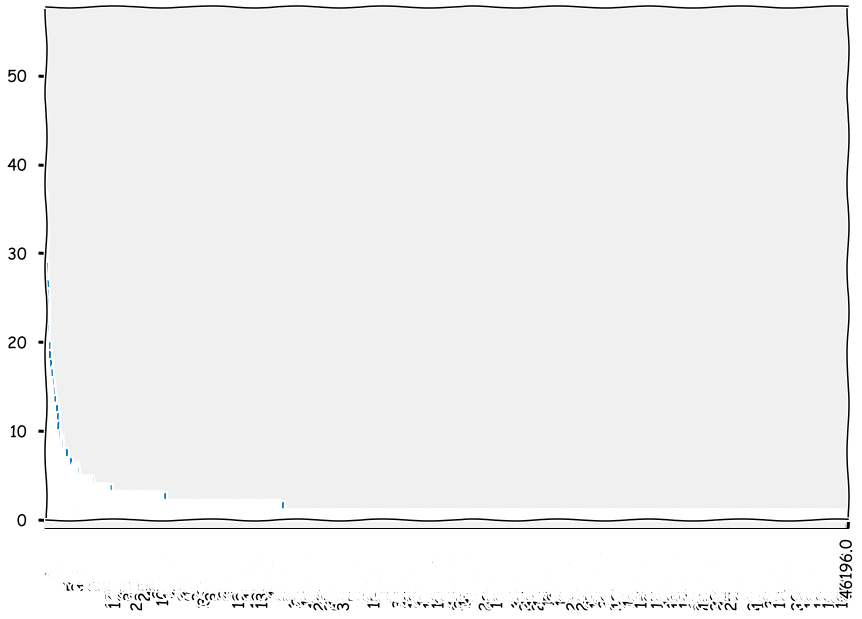

In [271]:
fig,ax = plt.subplots()
mod_df['TOTAL_TESTED'].value_counts().plot(ax=ax, kind='bar')
plt.plot()

In [263]:
mod_df['TOTAL_TESTED'] = mod_df['NEGATIVE']  +  mod_df['POSITIVE']  + mod_df['INCONCLUSIVE'] + mod_df['AWAITING_TESTING']

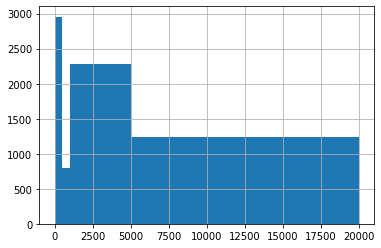

In [206]:
mod_df['TOTAL_TESTED'].hist(bins=[0,500,501,1000,1001,5000,5001,20000])

In [268]:
mod_df.to_csv('Final COVID Only Dataset 7-11-20.txt', sep='\t', index=False)
mod_df.to_csv('Final COVID Only Dataset 7-11-20.csv', sep=',', index=False)

In [242]:
plt.style.available

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

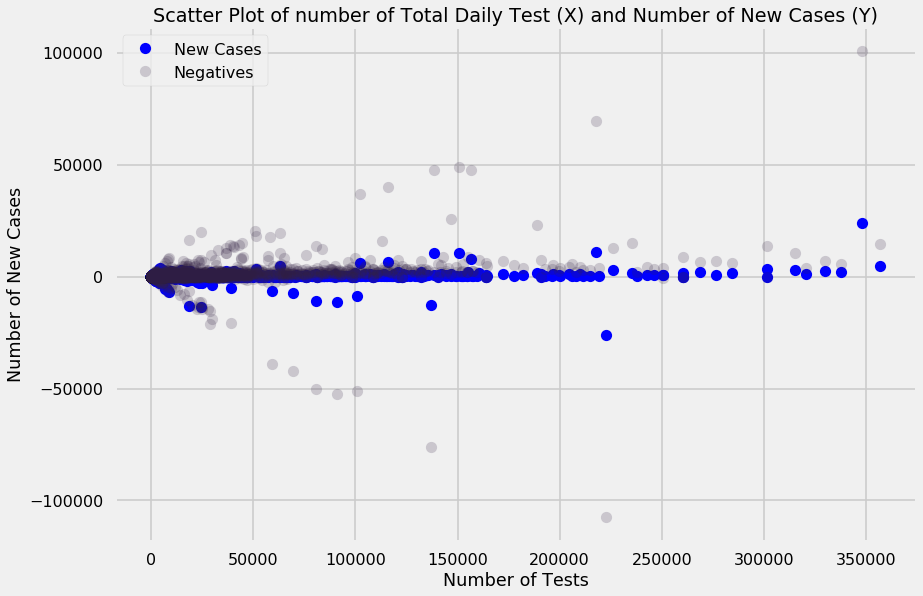

In [248]:
plt.style.use('seaborn-colorblind')
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_CASES'],'bo', label='New Cases')
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_NEGATIVES'], color='#332244',marker='o', linestyle='' , label= 'Negatives', alpha=0.2)
plt.title('Scatter Plot of number of Total Daily Test (X) and Number of New Cases (Y)')
plt.xlabel('Number of Tests')
plt.ylabel('Number of New Cases')
plt.legend()
plt.show()

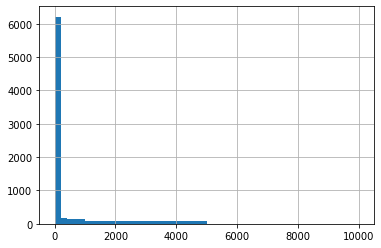

In [199]:
mod_df['NEW_CASES'].hist(bins=[0,199,200,399, 400,1000,1001,5000,5001,10000])

In [272]:
mod_df[['TOTAL_TESTED','COUNTY']].describe()

,TOTAL_TESTED
count,8116.000000
mean,8529.115451
std,24963.294120
min,1.000000
25%,188.000000
50%,1246.000000
75%,5207.500000
max,356791.000000


### Verifying that the shift worked correctly

In [176]:
mod_df[['COUNTY','NEGATIVE']].sum().to_frame()

,0
COUNTY,AlachuaAlachuaAlachuaAlachuaAlachuaAlachuaAlac...
NEGATIVE,6.28858e+07


### The extreme minimum and maximum might be  correct.
### In the case of negatives they are corrections.

In [274]:
mod_df['NEW_CASES'].describe().to_frame()

,NEW_CASES
count,8048.000000
mean,8.835239
std,492.056344
min,-23857.000000
25%,0.000000
50%,2.000000
75%,12.000000
max,4700.000000


In [275]:
mod_df.filter(items=['NEW_CASES','COUNTY'], axis=1)

,NEW_CASES,COUNTY
0,NaN,Alachua
1,3.0,Alachua
2,0.0,Alachua
3,0.0,Alachua
4,0.0,Alachua
...,...,...
8235,5.0,Washington
8236,1.0,Washington
8237,3.0,Washington
8239,-1.0,Washington


## Observations where the number of new cases is less than 0

In [277]:
# Getting Counties with over 1000 cases reported in one day
high_case = mod_df[mod_df['NEW_CASES']> 1000]
high_case.sort_values(by='NEW_CASES', inplace=True, ascending =False)
print(high_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(100))
top_100 = pd.DataFrame(high_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(100))


            COUNTY  NEW_CASES        DATE
1583          Dade     4700.0  07-05-2020
1474          Dade     3813.0  03-26-2020
1577          Dade     3518.0  06-28-2020
1579          Dade     3106.0  06-30-2020
730        Broward     3010.0  07-05-2020
620        Broward     2328.0  03-25-2020
1581          Dade     2304.0  07-02-2020
1488          Dade     2297.0  04-03-2020
1582          Dade     2046.0  07-03-2020
1574          Dade     1989.0  06-24-2020
5728        Orange     1954.0  07-05-2020
3487  Hillsborough     1900.0  06-28-2020
5722        Orange     1823.0  06-28-2020
622        Broward     1746.0  03-27-2020
1486          Dade     1701.0  04-02-2020
1490          Dade     1632.0  04-04-2020
1492          Dade     1602.0  04-05-2020
625        Broward     1553.0  03-29-2020
1576          Dade     1532.0  06-26-2020
5969    Palm Beach     1512.0  07-05-2020
3381  Hillsborough     1461.0  03-25-2020
624        Broward     1439.0  03-28-2020
1925         Duval     1417.0  06-

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [283]:
# County
pd.value_counts(high_case['COUNTY'].head(100)).to_frame(name="County")

,County
Dade,19
Broward,11
Orange,4
Hillsborough,4
Duval,3
Palm Beach,2


In [284]:
neg_case = mod_df[mod_df['NEW_CASES']< 0]
neg_case.sort_values(by='NEW_CASES', inplace=True)
print(neg_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(20))
print(neg_case[['COUNTY', 'NEW_CASES' ,'DATE']].tail(20))

            COUNTY  NEW_CASES        DATE
1584          Dade   -23857.0  07-06-2020
1494          Dade   -14305.0  04-06-2020
641        Broward   -13072.0  04-06-2020
731        Broward   -10986.0  07-06-2020
5729        Orange   -10489.0  07-06-2020
3494  Hillsborough   -10405.0  07-06-2020
5970    Palm Beach    -7940.0  07-06-2020
3404  Hillsborough    -7006.0  04-06-2020
1932         Duval    -6691.0  07-06-2020
1842         Duval    -6317.0  04-06-2020
6219      Pinellas    -6175.0  07-06-2020
5639        Orange    -5795.0  04-06-2020
6129      Pinellas    -5596.0  04-06-2020
4338           Lee    -4652.0  07-06-2020
6323          Polk    -3533.0  07-06-2020
5880    Palm Beach    -3466.0  04-06-2020
4248           Lee    -3062.0  04-06-2020
6794      Seminole    -2542.0  07-06-2020
1338       Collier    -2516.0  07-06-2020
1585          Dade    -2282.0  07-06-2020
          COUNTY  NEW_CASES        DATE
1755       Dixie       -1.0  04-26-2020
6634    Sarasota       -1.0  04-24-202

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
pd.value_counts(neg_case.COUNTY)

St. Johns    34
Collier      33
Brevard      33
Orange       33
Total        33
             ..
Gulf          9
Calhoun       8
Lafayette     8
Franklin      7
Glades        6
Name: COUNTY, Length: 69, dtype: int64

In [67]:
mod_df[mod_df['NEW_CASES']< 0].describe()

,Unnamed: 0,AWAITING_TESTING,INCONCLUSIVE,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,NEW_NEGATIVES,NEW_CASES
count,1548.000000,1396.000000,779.000000,1.547000e+03,1548.000000,1548.000000,7.080000e+02,1547.000000,1548.000000
mean,2962.465762,56.161175,28.057766,7.762021e+03,1454.863695,89.988372,1.802531e+04,-1925.260504,-484.986434
std,2059.319013,195.983714,108.466943,4.923870e+04,6297.361781,629.437455,7.702989e+04,29389.717986,5302.518945
min,508.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.200000e+01,-845018.000000,-129140.000000
25%,1519.750000,2.000000,1.000000,0.000000e+00,61.000000,5.000000,1.426250e+03,-31.000000,-39.000000
50%,2450.500000,8.000000,2.000000,5.010000e+02,179.500000,8.000000,3.333000e+03,0.000000,-6.000000
75%,3804.250000,29.000000,7.000000,2.972000e+03,584.000000,16.000000,9.616250e+03,0.000000,-2.000000
max,8240.000000,1551.000000,1221.000000,1.264928e+06,101253.000000,12151.000000,1.338137e+06,110975.000000,-1.000000


In [36]:
# mod_df.drop('FILE_NAME1', axis = 1, inplace=True)
mod_df.columns

Index(['Unnamed: 0', 'COUNTY', 'AWAITING_TESTING', 'INCONCLUSIVE', 'NEGATIVE',
       'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME', 'DATE',
       'NEW_NEGATIVES', 'NEW_CASES'],
      dtype='object')

# Messing around with matplotlib

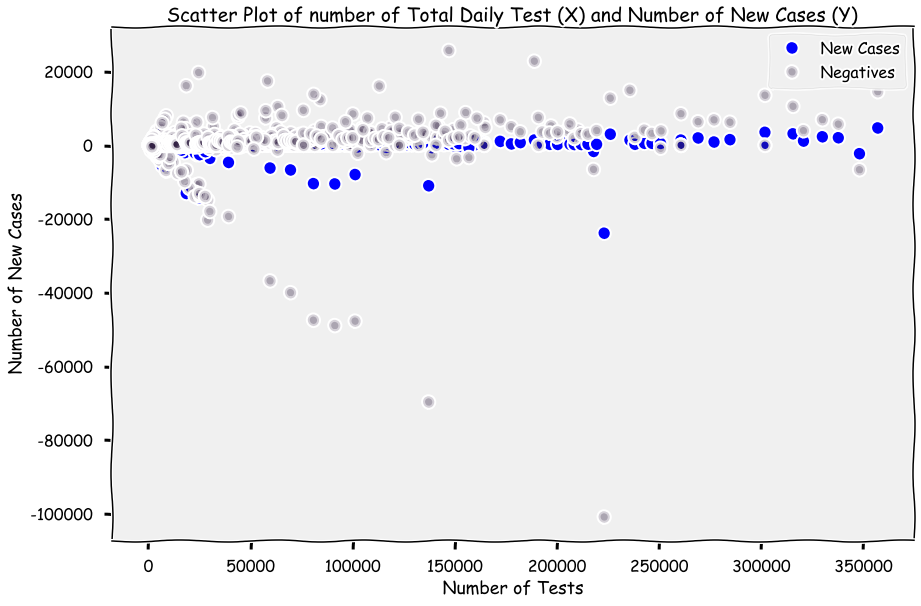

In [265]:
plt.xkcd()
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_CASES'],'bo', label='New Cases')
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_NEGATIVES'], color='#332244',marker='o', linestyle='' , label= 'Negatives', alpha=0.2)
plt.title('Scatter Plot of number of Total Daily Test (X) and Number of New Cases (Y)')
plt.xlabel('Number of Tests')
plt.ylabel('Number of New Cases')
plt.legend()
plt.savefig('plot.png')
plt.show()